In [78]:
# ###############################################################################################
# LSTM RNN machine learing model is applied to predict the next close price .
# output: next day close prices.
# input window size: 60 days
#################################################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
# Read in data from Heroku API
import json, requests

In [91]:
name='bk'

In [92]:

url = f"http://magic-stocks.herokuapp.com/api/v1/metrics/{name}"

#url="https://cors-anywhere.herokuapp.com/magic-stocks.herokuapp.com/api/v1/metrics/aapl"
response = requests.get(url).json()
aapl = pd.DataFrame(response)
aapl.head()

,adj_close,close,date,direction,dividend,high,id,low,next_close,open_amt,roc,rsi,slowd,slowk,sma,split,std,ticker,volume,willr
0,21.5119,26.23,2010-07-09,1,0.0,26.24,4,25.75,26.27,25.97,-1.3168,50.3306,69.5356,85.7936,25.6100,1.0,0.99445,BK,5400600,-24.4604
1,21.5447,26.27,2010-07-12,1,0.0,26.39,15,26.03,26.85,26.10,-0.5678,50.6905,79.1860,81.3300,25.5993,1.0,0.97630,BK,4736900,-18.0077
2,22.0204,26.85,2010-07-13,-1,0.0,26.95,26,26.46,26.61,26.48,2.2857,55.7029,84.8294,87.3645,25.6421,1.0,1.06420,BK,10718800,-3.5461
3,21.8236,26.61,2010-07-14,1,0.0,26.81,37,26.42,26.79,26.63,1.8760,53.2890,84.2320,84.0016,25.6771,1.0,1.11515,BK,7324900,-12.0567
4,21.9712,26.79,2010-07-15,-1,0.0,26.91,48,26.25,25.73,26.54,4.9765,54.8687,85.2791,84.4712,25.7679,1.0,1.19165,BK,8062300,-5.6738


In [93]:
#Sort the dataset on date time and filter “Date” and “Close” columns:

df=aapl[['date', 'high', 'low', 'close','volume']]
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','close'])
for i in range(0,len(data)):
    new_dataset["date"][i]=data['date'][i]
    new_dataset["close"][i]=data["close"][i]

In [94]:
new_dataset.drop("date",axis=1,inplace=True)


In [95]:
#Normalize the new filtered datasetand split data to train and test dataset:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:1200,:]
valid_data=final_dataset[1200:,:]
#new_dataset.set_index('date',inplace=True)
#new_dataset.drop("date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [96]:
y_train_data

array([0.20898821, 0.2151277 , 0.22372299, ..., 0.5709725 , 0.57367387,
       0.57539293])

In [97]:
#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

Epoch 1/1
 - 133s - loss: 0.0012


In [98]:
#Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [99]:
valid_data.shape
inputs_data.shape

(1378, 1)

In [100]:
#Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [101]:
# serialize model to JSON
model_json = lstm_model.to_json()
with open(f"{name}_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights(f"{name}_model.h5")
print("Saved model to disk")

Saved model to disk


/Users/jadetao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


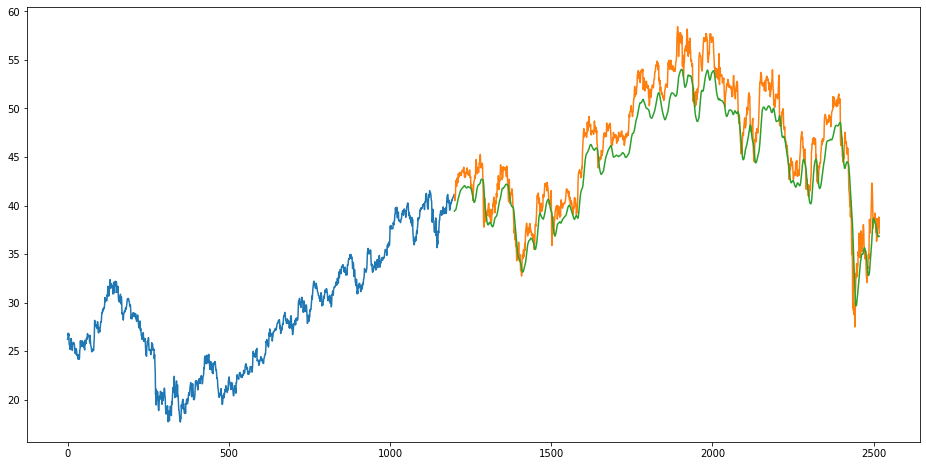

In [102]:
train_data=new_dataset[:1200]
valid_data=new_dataset[1200:]
valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(16,8))
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"Predictions"]])
plt.savefig(f'{name}_plot.png',dpi=300)
plt.show()